# International Stock Market Visualization

In [78]:
import math
from datetime import datetime, timedelta
from dateutil.relativedelta import relativedelta, FR

from bokeh.plotting import figure, show
from bokeh.models import TickFormatter, MultiSelect, CustomJS, ColumnDataSource, HoverTool
from bokeh.layouts import row
from bokeh.palettes import Category10, Category20, Category20b, Category20c
from bokeh.util.compiler import TypeScript
from bokeh.io import output_notebook
output_notebook()

import pandas as pd
pd.set_option('display.max_rows', 100) 

import os
import numpy as np
import sqlite3 as sl
from sqlite3 import Error

import json
import matplotlib.pyplot as plt

import requests
from requests.structures import CaseInsensitiveDict
import urllib.parse

import quandl
secrets = json.load(open("secrets.json", "r"))
quandl.ApiConfig.api_key = secrets["nasdaq-quandl"]["api-key"]


Loading BokehJS ...

## Create database if not exists
To avoid too much queries and unnecessary data updates, we create/load a database.
We define that we are only interested in the data until last Friday.

In [88]:
start_date = datetime(2010, 1, 1)
last_date = start_date
date_of_last_friday = datetime.now() + relativedelta(weekday=FR(-1))
print("last friday is", date_of_last_friday.isoformat(timespec='milliseconds'))

db_abs_path = os.path.abspath('international_data.db')
db_conn = sl.connect(db_abs_path)

# create table 'currency' if not exists
db_conn.execute("""create table if not exists currency 
            (date DATE, USD_EUR FLOAT, USD_CNY FLOAT, USD_JPY FLOAT, USD_GBP FLOAT,
            PRIMARY KEY (date))""")

# create table 'commodity' if not exists
db_conn.execute("""create table if not exists commodity 
            (date DATE, OIL FLOAT, GOLD FLOAT, SILVER FLOAT,
            PRIMARY KEY (date))""")

last friday is 2023-05-12T21:06:04.368


## Get currency history
Get exchange rates until last Friday.
https://app.freecurrencyapi.com/request-playground

In [67]:
currency_df = pd.read_sql_query("SELECT * FROM currency", db_conn)
if len(currency_df.index)>0:
    dates = pd.to_datetime(currency_df['date'])
    last_date = dates.max()

if last_date < date_of_last_friday:
    api_key = secrets["freecurrencyapi"]["api-key"]

    delta_in_s = (date_of_last_friday - last_date).total_seconds()
    years = int(divmod(delta_in_s, 31536000)[0])

    if years > 0:
        print(f"delta is too large: {years}. we split the timeslot to years.")
        for i in range(years):
            url = f"https://api.freecurrencyapi.com/v1/historical?apikey={api_key}&currencies=EUR%2CCNY%2CJPY%2CGBP&"+ \
            f"date_from={urllib.parse.quote((last_date + relativedelta(years=i)).isoformat(timespec='milliseconds'))}Z&"+ \
            f"date_to={urllib.parse.quote((last_date + relativedelta(years=i+1)).isoformat(timespec='milliseconds'))}Z"

            resp = requests.get(url)
            if resp.status_code == 200:
                data = json.loads(resp.content)["data"]
                
                for key, value in data.items():
                    row = pd.DataFrame({'date': [key], 'USD_EUR': [value["EUR"]], "USD_CNY": [value["CNY"]], "USD_JPY": [value["JPY"]], "USD_GBP": [value["GBP"]]})
                    currency_df = pd.concat([currency_df, row], ignore_index=True)
        last_date = last_date + relativedelta(years=years)
    
    url = f"https://api.freecurrencyapi.com/v1/historical?apikey={api_key}&currencies=EUR%2CCNY%2CJPY%2CGBP&"+\
        f"date_from={urllib.parse.quote(last_date.isoformat(timespec='milliseconds'))}Z&date_to={urllib.parse.quote(date_of_last_friday.isoformat(timespec='milliseconds'))}Z"
    print(url)
    resp = requests.get(url)
    if resp.status_code == 200:
        print("success")
        data = json.loads(resp.content)["data"]
        
        for key, value in data.items():
            row = pd.DataFrame({'date': [key], 'USD_EUR': [value["EUR"]], "USD_CNY": [value["CNY"]], "USD_JPY": [value["JPY"]], "USD_GBP": [value["GBP"]]})
            currency_df = pd.concat([currency_df, row], ignore_index=True)
        
        print(currency_df.head(5))
        currency_df.to_sql('currency', db_conn, if_exists='replace')
    else:
        print("failure with status code:", resp.status_code, resp.content)


delta is too large: 13. we split the timeslot to years.
https://api.freecurrencyapi.com/v1/historical?apikey=ctRZcHxbmXYjzUQO2pqDnhBJAlb8VfgpoKwQlwZq&currencies=EUR%2CCNY%2CJPY%2CGBP&date_from=2023-01-01T00%3A00%3A00.000Z&date_to=2023-05-12T14%3A11%3A47.416Z
success
         date  USD_EUR  USD_CNY   USD_JPY  USD_GBP
0  2010-01-01  0.69727  6.82893  92.91181  0.61823
1  2010-01-02  0.69610  6.82894  92.74270  0.61788
2  2010-01-03  0.69609  6.82893  92.74301  0.61788
3  2010-01-04  0.69393  6.82821  92.64924  0.62049
4  2010-01-05  0.69495  6.82764  91.66565  0.62449


We check development of international currency market.

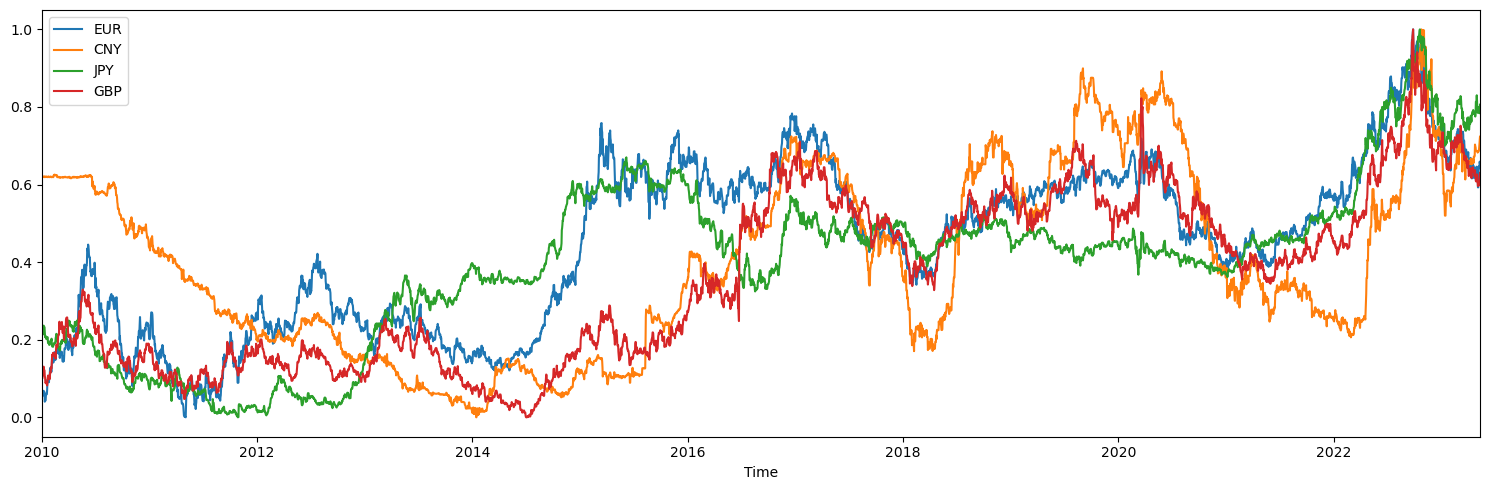

In [77]:
currency_df["date"] = pd.to_datetime(currency_df["date"])

fig, ax = plt.subplots(figsize=(15,5))

for cur in ['EUR', 'CNY', 'JPY', 'GBP']:
    raw_data = currency_df['USD_'+cur]
    normalized = (raw_data - raw_data.min())/(raw_data.max() - raw_data.min())
    ax.plot(currency_df['date'], normalized, label=cur)

ax.set_xlabel('Time')
plt.xlim(currency_df['date'].min(), currency_df['date'].max())
plt.legend()
plt.tight_layout()
plt.show()

## Get commodity and futures prices

In [96]:
last_date = start_date
# commodity_df = pd.read_sql_query("SELECT * FROM commodity", db_conn)
# if len(commodity_df.index)>0:
#     dates = pd.to_datetime(currency_df['date'])
#     last_date = dates.max()
    
# get oil price
df = quandl.get('OPEC/ORB', start_date=last_date.strftime("%Y-%m-%d"), end_date=date_of_last_friday.strftime("%Y-%m-%d"))
result_df = df.rename(columns={"Value": "OIL"})
result_df.index.names=["date"]

# get gold price
df = quandl.get('LBMA/GOLD', start_date=last_date.strftime("%Y-%m-%d"), end_date=date_of_last_friday.strftime("%Y-%m-%d"))
df.index.names=["date"]
result_df = result_df.join(df[["USD (PM)"]].rename(columns={"USD (PM)": "GOLD"}))

# get silver price
df = quandl.get('LBMA/SILVER', start_date=last_date.strftime("%Y-%m-%d"), end_date=date_of_last_friday.strftime("%Y-%m-%d"))
df.index.names=["date"]
result_df = result_df.join(df[["USD"]].rename(columns={"USD": "SILVER"}))

commodity_df = result_df
commodity_df.to_sql('commodity', db_conn, if_exists='replace')
commodity_df.head(5)


IndexError: too many indices for array

In [95]:
commodity_df["date"] = pd.to_datetime(commodity_df["date"])

fig, ax = plt.subplots(figsize=(15,5))

for comm in ['OIL', 'GOLD', 'SILVER']:
    raw_data = commodity_df[comm]
    normalized = (raw_data - raw_data.min())/(raw_data.max() - raw_data.min())
    ax.plot(commodity_df['date'], normalized, label=comm)

ax.set_xlabel('Time')
plt.xlim(commodity_df['date'].min(), commodity_df['date'].max())
plt.legend()
plt.tight_layout()
plt.show()

KeyError: 'date'

## Explore stock markets and record symbols for further steps
Get all symbols by countries, indices, industries

In [72]:
from pytickersymbols import PyTickerSymbols

stock_data = PyTickerSymbols()
countries = stock_data.get_all_countries()
indices = stock_data.get_all_indices()
industries = stock_data.get_all_industries()

de_dax_stocks = stock_data.get_stocks_by_index('DAX')
uk_ftse_stocks = stock_data.get_stocks_by_index('FTSE 100')

stock_data.get_all_stocks()[0]

{'name': 'adidas AG',
 'symbol': 'ADS',
 'country': 'Germany',
 'indices': ['DAX', 'EURO STOXX 50'],
 'industries': ['Cyclical Consumer Products',
  'Footwear',
  'Textiles & Apparel',
  'Consumer Cyclicals',
  'Sportswear',
  'Toiletries'],
 'symbols': [{'yahoo': 'ADS.F', 'google': 'FRA:ADS', 'currency': 'EUR'},
  {'yahoo': 'ADDDF', 'google': 'OTCMKTS:ADDDF', 'currency': 'USD'},
  {'yahoo': 'ADDYY', 'google': 'OTCMKTS:ADDYY', 'currency': 'USD'},
  {'yahoo': 'ADS1.F', 'google': 'FRA:ADS1', 'currency': 'EUR'}],
 'metadata': {'founded': 1924, 'employees': 57016},
 'isins': ['DE000A1EWWW0'],
 'akas': []}

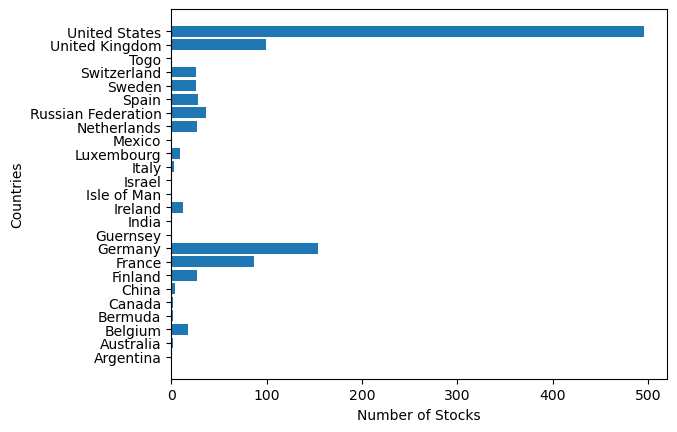

In [74]:
stock_info_df = pd.read_json(json.dumps(stock_data.get_all_stocks()))
stock_info_df.drop(['wiki_name', 'akas'], inplace=True, axis=1)     # remove unused columns
df = stock_info_df.groupby(['country'])['country'].count().reset_index(name="count")

fig, ax = plt.subplots()
y_pos = np.arange(len(df["country"]))
ax.barh(y_pos, df["count"])
ax.set_xlabel('Number of Stocks')
ax.set_yticks(y_pos, labels=df["country"])
ax.set_ylabel('Countries')
plt.show()

Extract all yahoo tickers

In [75]:
yahoo_tickers = stock_info_df.assign(ticker=lambda x: x['symbols'])

# remove stock with empty symbol
yahoo_tickers = yahoo_tickers.drop(yahoo_tickers[yahoo_tickers["ticker"].apply(lambda x: len(x))==0].index)
# extract yahoo symbol
yahoo_tickers["ticker"] = yahoo_tickers["ticker"].apply(lambda x: x[0]['yahoo'])
yahoo_tickers.head(5)

,name,symbol,country,indices,industries,symbols,metadata,isins,ticker
0,adidas AG,ADS,Germany,"[DAX, EURO STOXX 50]","[Cyclical Consumer Products, Footwear, Textile...","[{'yahoo': 'ADS.F', 'google': 'FRA:ADS', 'curr...","{'founded': 1924, 'employees': 57016}",[DE000A1EWWW0],ADS.F
1,Allianz SE,ALV,Germany,"[DAX, EURO STOXX 50]","[Insurance, Financials, Multiline Insurance & ...","[{'yahoo': 'ALV.F', 'google': 'FRA:ALV', 'curr...","{'founded': 1890, 'employees': 147268}",[DE0008404005],ALV.F
2,BASF SE,BAS,Germany,"[DAX, EURO STOXX 50]","[Diversified Chemicals, Basic Materials, Chemi...","[{'yahoo': 'BAS.F', 'google': 'FRA:BAS', 'curr...","{'founded': 1865, 'employees': 117628}",[DE000BASF111],BAS.F
3,Bayer AG,BAYN,Germany,"[DAX, EURO STOXX 50]","[Pharmaceuticals, Pharmaceuticals & Medical Re...","[{'yahoo': 'BAYN.F', 'google': 'FRA:BAYN', 'cu...","{'founded': 1863, 'employees': 103824}",[DE000BAY0017],BAYN.F
4,Beiersdorf AG,BEI,Germany,[DAX],"[Consumer Non-Cyclicals, Personal Products, Pe...","[{'yahoo': 'BEI.F', 'google': 'FRA:BEI', 'curr...","{'founded': 1882, 'employees': 20306}",[DE0005200000],BEI.F


Parse industry and stock list

In [76]:
import yfinance as yf

msft = yf.Ticker("SMEGF") # MSFT, SMEGF
msft.info

{'address1': 'Otto-Hahn-Ring 6',
 'city': 'Munich',
 'zip': '81739',
 'country': 'Germany',
 'phone': '49 89 636 00',
 'website': 'https://www.siemens-energy.com',
 'industry': 'Specialty Industrial Machinery',
 'industryDisp': 'Specialty Industrial Machinery',
 'sector': 'Industrials',
 'longBusinessSummary': 'Siemens Energy AG operates as an energy technology company worldwide. It operates in two segments, Gas and Power; and Siemens Gamesa Renewable Energy. The company provides gas and steam turbines, generators, gas engines, instrumentation and controls, and electrical systems, as well as performance enhancement, maintenance, customer training, and professional consulting services for central and distributed power generation; and transformers, air and gas-insulated switchgears, AC transmission systems, offshore windfarm grid connections, high voltage direct current transmission systems, high voltage substations, digital solutions and components, and other products. It also offers ro

{'address1': 'Klarabergsviadukten 70',
 'address2': 'Section B7 Box 70381',
 'city': 'Stockholm',
 'zip': '111 64',
 'country': 'Sweden',
 'phone': '46 8 58 72 06 00',
 'website': 'https://www.autoliv.com',
 'industry': 'Auto Parts',
 'industryDisp': 'Auto Parts',
 'sector': 'Consumer Cyclical',
 'longBusinessSummary': 'Autoliv, Inc., through its subsidiaries, develops, manufactures, and supplies passive safety systems to the automotive industry in Europe, the Americas, China, Japan, and rest of Asia. It offers passive safety systems, including modules and components for frontal-impact airbag protection systems, side-impact airbag protection systems, seatbelts, steering wheels, and inflator technologies. The company also provides mobility safety solutions, such as pedestrian protection, battery cut-off switches, connected safety services, and safety solutions for riders of powered two wheelers. It primarily serves car manufacturers. Autoliv, Inc. was founded in 1953 and is headquartere

Comparison of total market values among industries in China

In [6]:
latest_values = joined.iloc[-1]
timestamp = pd.to_datetime(latest_values['times']).strftime("%Y-%m-%d")
industry_names = joined.columns.tolist()[1:]
values = latest_values.values.tolist()[1:]

p = figure(y_range=industry_names, height=1000)
p.yaxis.axis_label = '产业类型 Industries'
p.xaxis.axis_label = '收盘价 Closing Prices (人民币 RMB)'
# [i for i in range(86)]
p.hbar(y=industry_names, right=values, height=1)
show(p)

In [9]:
recent_data = joined.tail(100)
recent_data['times'] = pd.to_datetime(recent_data['times']).dt.strftime("%Y-%m-%d")

p = figure(x_range=recent_data['times'], width=800, height=500)

industry_names = recent_data.columns.tolist()[1:]
for idx, col in enumerate(industry_names):
    data = recent_data[['times', col]]
    data['name'] = col
    data.rename(columns={col: 'values'}, inplace=True)
    source = ColumnDataSource(data)     # times, values, name
    p.line(x='times', y='values', source=source, legend_label=col, name=col, 
            color=Category20b[20][idx%20])

# p.xaxis.formatter = MyFormatter()
p.xaxis.major_label_orientation = math.pi/4
p.legend.click_policy="hide"
p.legend.visible=False

hover = HoverTool(tooltips=[('Industry','@name'), ('Value', '@values')])
p.add_tools(hover)

ms = MultiSelect(title='Industries:', options=industry_names, value=industry_names, height=500)
ms.js_on_change('value', CustomJS(args=dict(legend=p.legend[0]),
                                  code="""\
    const {LegendItem} = Bokeh.require('models/annotations/legend_item');
    legend.visible = true;
    legend.items = cb_obj.value.map((v) => {
        return new LegendItem({label: {value: v},
                               renderers: [cb_obj.document.get_model_by_name(v)]});
    });
"""))

show(row(p, ms))

c:\Users\yangt\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
c:\Users\yangt\anaconda3\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
c:\Users\yangt\anaconda3\lib\site-packages\pandas\core\frame.py:4133: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/

Release all resources

In [8]:
db_conn.close()